In [147]:
import numpy as np
import matplotlib.pyplot as plt
import tomlkit

from pathlib import Path

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 100 # 200 e.g. is really fine, but slower

#### Constants

In [148]:
spy = 365.0 * 86400.0

#### Load species list

In [149]:
with open("naunet_config.toml") as config:
    content = tomlkit.loads(config.read())

summary = content["summary"]
cur_species = summary["list_of_species"]
cur_nspec = summary["num_of_species"]

In [150]:
refpath = Path("benchmark")
data = np.loadtxt(refpath / "evolution.dat")

# ref_species = np.genfromtxt(refpath / "species.txt", usecols=1, dtype=str)
ref_species = np.genfromtxt(refpath / "species.txt", dtype=str, comments="$")
ref_nspec = len(ref_species)

#### Time evolution of species

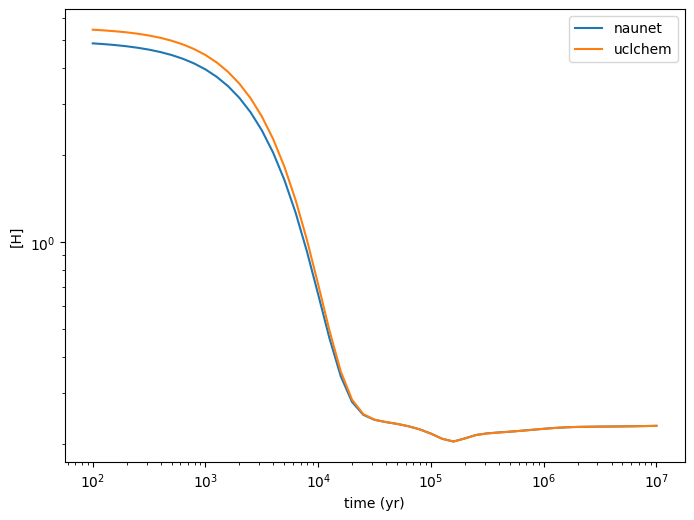

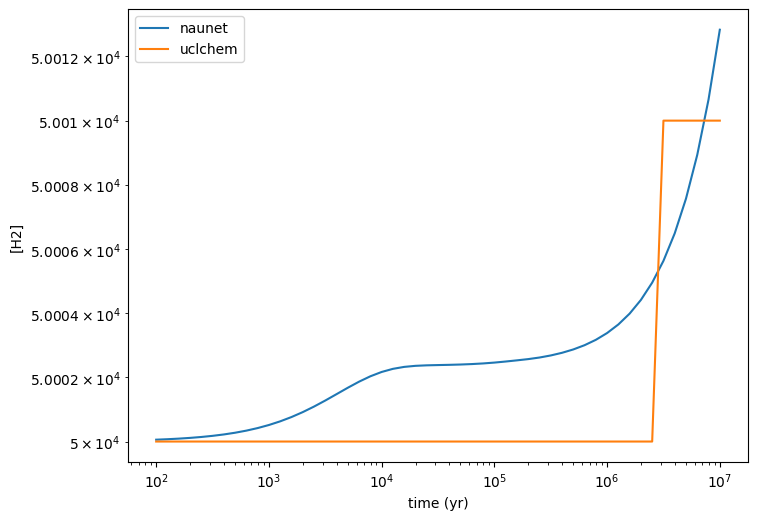

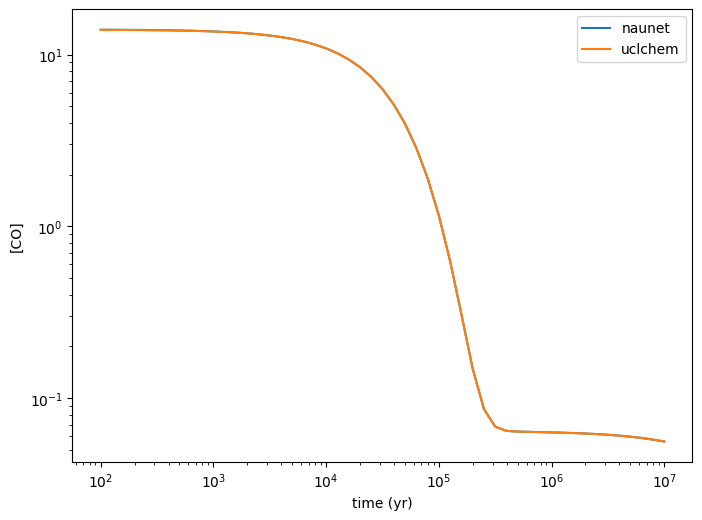

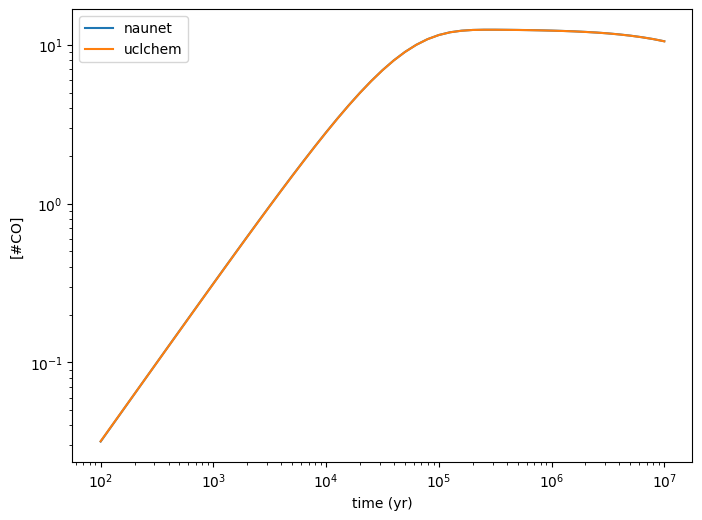

In [151]:
spec = "CO"

for spec in ["H", "H2", "CO", "#CO"]:

    bindata = np.fromfile(f"build/tests/evolution_singlegrid.bin", dtype="float64").reshape(-1, cur_nspec+1)
    cur_time = bindata[:, 0]
    cur_sidx = cur_species.index(spec) + 1
    cur_data = bindata[:, cur_sidx]

    ref_time = data[:, 0]
    # ref_time = np.append(0.0, ref_time)
    # ref_ntime = len(time)
    # ref_nH = np.loadtxt(refpath / "test_input.dat")[0, 2]
    with open(refpath / "staticpoint.inp") as inp:
        for line in inp.readlines():
            if "initialDens" in line:
                ref_nH = float(line.split()[1])

    ref_sidx, = np.where(ref_species == spec)
    ref_sidx += 1 # fisrt column is time
    ref_data = data[:, ref_sidx] * ref_nH

    fig, ax = plt.subplots()
    ax.plot(cur_time[1:], cur_data[1:], label="naunet");
    # ax.scatter(cur_time, cur_data);
    ax.plot(ref_time, ref_data, label="uclchem");
    ax.set_xscale("log");
    ax.set_yscale("log");
    ax.set_xlabel("time (yr)");
    ax.set_ylabel(f"[{spec}]");
    ax.legend();
    # plt.savefig("H2evolve.png")

#### Performance

Time consumption ratio:  0.5253268968115823


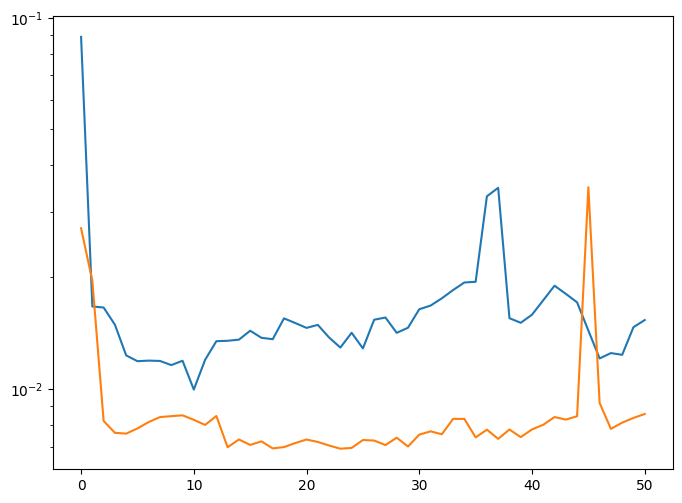

In [152]:
ref_perftime = np.loadtxt(refpath / "time.txt")[:, 1]
cur_perftime = np.loadtxt("build/tests/time_singlegrid.txt")

fig, ax = plt.subplots()

ax.plot(np.arange(0, len(cur_perftime)), cur_perftime);
ax.plot(np.arange(0, len(ref_perftime)), ref_perftime);

ax.set_yscale("log")

print("Time consumption ratio: ", np.sum(ref_perftime) / np.sum(cur_perftime))

#### Check reaction rates (need turn on reaction rate output, only for debug)

(array([1373]),)
3.3982479e-24 3.3982464e-24
[8.0687153e+10 1.5852959e+09 1.4769231e-15 1.0438606e-20 1.0000000e-55
 1.0000000e-55 1.4769231e-15 1.0000000e-55 1.0000000e-55 1.0000000e-55
 1.9200000e-15 1.0000000e-55 1.0000000e-55 1.0000000e-55 1.4769231e-15
 1.0000000e-55 1.0000000e-55 1.0000000e-55 1.4769231e-15 1.0000000e-55
 1.0000000e-55 1.0000000e-55 1.4769231e-15 1.7674106e-48 8.0687153e+10
 1.5852959e+09 3.9876923e-15 4.0698361e-21 8.0687153e+10 1.5852959e+09
 2.6584615e-16 3.2592181e-12 1.0000000e-55 1.0000000e-55 1.4769231e-15
 1.0000000e-55 1.0000000e-55 1.5852959e+09 1.4769231e-15 1.5829829e-35
 1.0000000e-55 1.0000000e-55 1.4769231e-15 1.6767129e-48 1.0000000e-55
 1.0000000e-55 1.4769231e-15 1.6494475e-48 8.0687153e+10 1.5852959e+09
 1.4769231e-15 2.8522077e-18 1.0000000e-55 1.0000000e-55 3.1015384e-15
 1.0000000e-55 1.0000000e-55 1.0000000e-55 1.4769231e-15 1.0000000e-55
 1.0000000e-55 1.0000000e-55 1.4769231e-15 1.0000000e-55 1.0000000e-55
 1.0000000e-55 1.4769231e-15 1.0

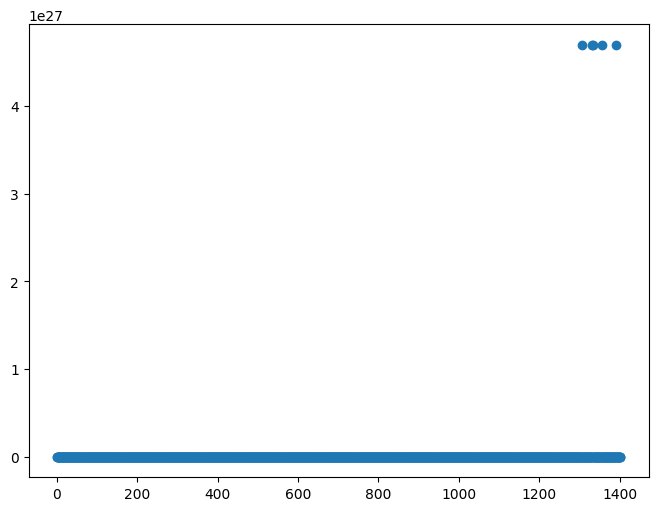

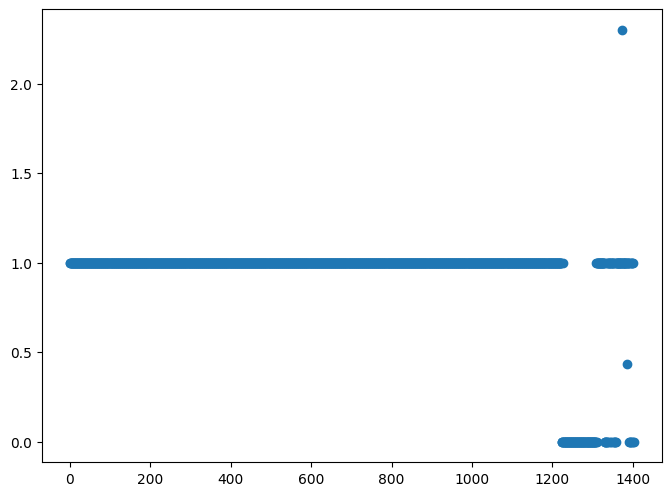

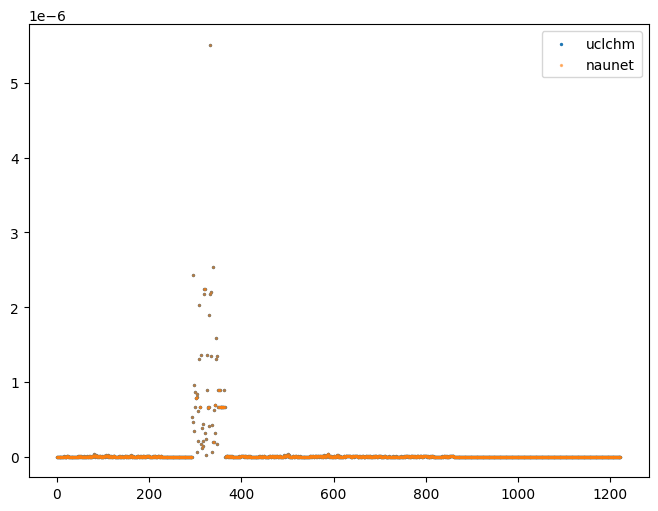

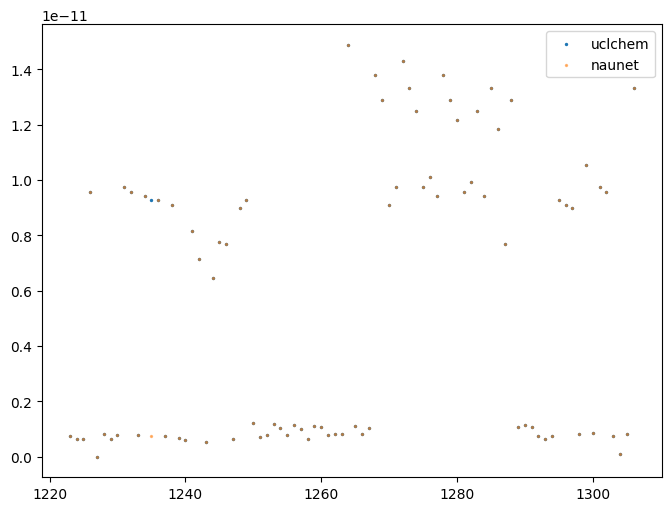

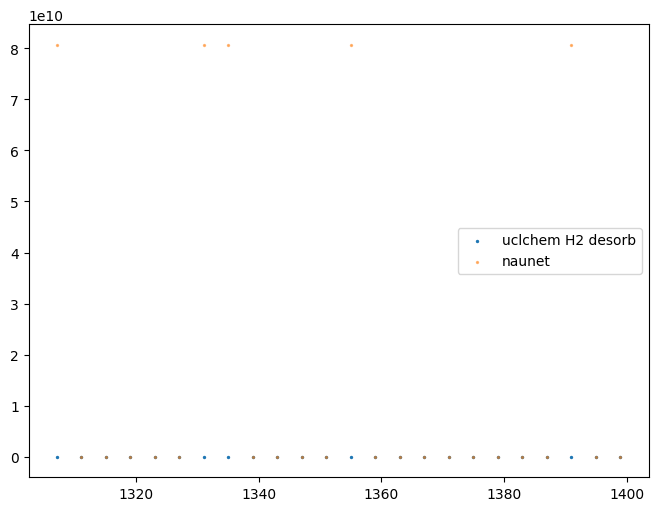

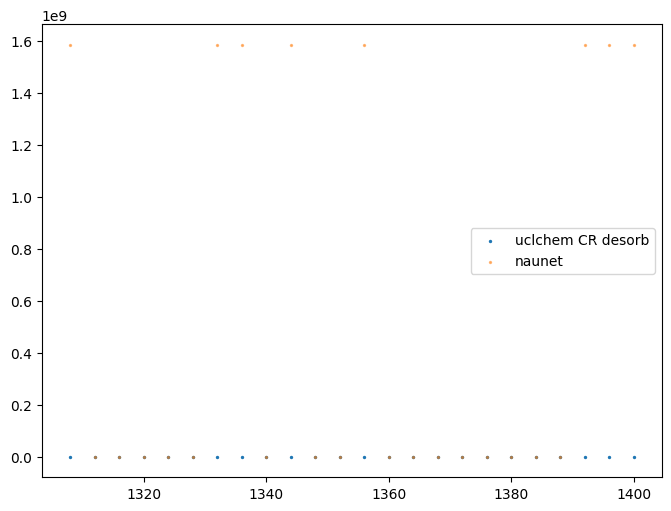

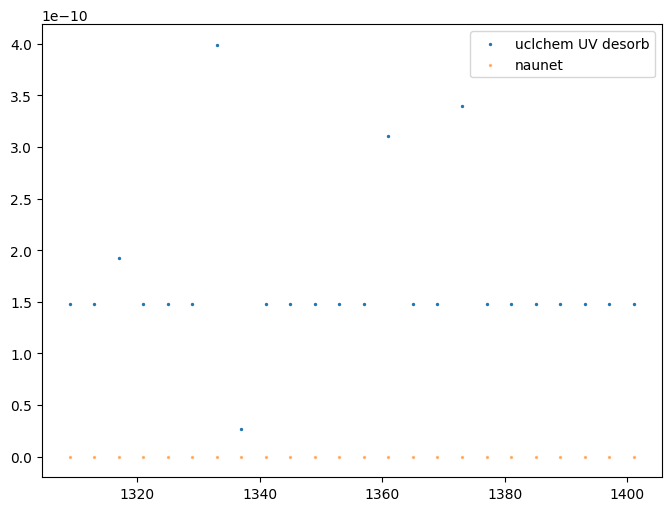

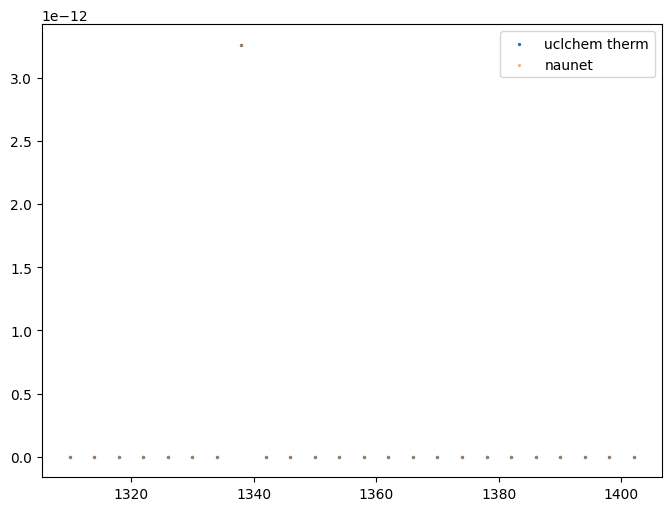

In [153]:
cur_rates = np.loadtxt("build/tests/reactionrates.txt")[0, :]
cur_rates = np.where(cur_rates < 1e-55, 1e-55, cur_rates)

ref_rates = []
with open(refpath / "rates.txt", "r") as inp:
    for line in inp.readlines()[1408:2811]:
        # print(line.split()[-1])
        ref_rates.append(float(line.split()[-1]))

ref_rates = np.array(ref_rates)
ref_rates = np.where(ref_rates < 1e-55, 1e-55, ref_rates)

fig, ax = plt.subplots()

ax.scatter(np.arange(0, 1403), cur_rates/ref_rates)

fig, ax = plt.subplots()

ax.scatter(np.arange(0, 1403), ref_rates/cur_rates)

print(np.where(ref_rates / cur_rates > 2))
print(ref_rates[1107], cur_rates[1107])

# fig, ax = plt.subplots(nrows=2, ncols=2)
# fig.set_size_inches(10, 8)

fig, ax = plt.subplots()
ax.scatter(np.arange(0, 1223), ref_rates[:1223], s=2, label="uclchm")
ax.scatter(np.arange(0, 1223), cur_rates[:1223], s=2, alpha=0.5, label="naunet")
ax.legend();

fig, ax = plt.subplots()
ax.scatter(np.arange(1223, 1307), ref_rates[1223:1307] * ref_nH, s=2, label="uclchem")
ax.scatter(np.arange(1223, 1307), cur_rates[1223:1307], s=2, alpha=0.5, label="naunet")
ax.legend();

print(cur_rates[1307:])

fig, ax = plt.subplots()
ax.scatter(np.arange(1307, 1403, 4), ref_rates[1307::4], s=2, label="uclchem H2 desorb")
ax.scatter(np.arange(1307, 1403, 4), cur_rates[1307::4], s=2, alpha=0.5, label="naunet")
ax.legend();

fig, ax = plt.subplots()
ax.scatter(np.arange(1308, 1403, 4), ref_rates[1308::4] * ref_nH, s=2, label="uclchem CR desorb")
ax.scatter(np.arange(1308, 1403, 4), cur_rates[1308::4], s=2, alpha=0.5, label="naunet")
ax.legend();

fig, ax = plt.subplots()
ax.scatter(np.arange(1309, 1403, 4), ref_rates[1309::4] * ref_nH, s=2, label="uclchem UV desorb")
ax.scatter(np.arange(1309, 1403, 4), cur_rates[1309::4], s=2, alpha=0.5, label="naunet")
ax.legend();

fig, ax = plt.subplots()
ax.scatter(np.arange(1310, 1403, 4), ref_rates[1310::4] * ref_nH, s=2, label="uclchem therm")
ax.scatter(np.arange(1310, 1403, 4), cur_rates[1310::4], s=2, alpha=0.5, label="naunet")
ax.legend();

# ax[0][0].scatter(np.arange(0, 1223), ref_rates[:1223], s=2)
# ax[0][0].scatter(np.arange(0, 1223), cur_rates[:1223], s=2, alpha=0.5)

# ax[0][1].scatter(np.arange(7070, 7616), ref_rates[7070:7616], s=2)
# ax[0][1].scatter(np.arange(7070, 7616), cur_rates[7070:7616], s=2, alpha=0.5)

# ax[1][0].scatter(np.arange(7616, 8273), ref_rates[7616:8273], s=2)
# ax[1][0].scatter(np.arange(7616, 8273), cur_rates[7616:8273], s=2, alpha=0.5)

# ax[1][1].scatter(np.arange(8273, 8764), ref_rates[8273:], s=2)
# ax[1][1].scatter(np.arange(8273, 8764), cur_rates[8273:], s=2, alpha=0.5)


In [154]:
len(cur_rates)

1403